**1. Downloading and Installing required libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import re
import nltk
import spacy
import string

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
! pip install --upgrade transformers datasets torch

In [5]:
!pip install -qq datasets

In [6]:
! pip install -qq evaluate
! pip install -qq transformers datasets
! pip install -qq transformers[torch] --force-reinstall
! pip install -qq accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.5/705.5 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.0/774.0 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [7]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
import torch.nn.functional as F
import evaluate

**2. Preparing the dataset**

In [8]:
from datasets import load_dataset

dataset = load_dataset("davanstrien/WELFake")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/72134 [00:00<?, ? examples/s]

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'label'],
        num_rows: 72134
    })
})

**3. Converting dataset from library to Pandas DataFrame for data preprocessing**

In [10]:
df = pd.concat([dataset[split].to_pandas() for split in dataset.keys()], ignore_index=True)
df.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,None,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [11]:
df.shape

(72134, 3)

**4. Removing null values**

In [12]:
null_values = df.isnull().sum()
null_values

title    558
text      39
label      0
dtype: int64

In [13]:
df.dropna(inplace=True)
df.shape

(71537, 3)

In [14]:
df["text"] = df["title"] + df["text"]
df.drop("title", axis=1, inplace=True)
df.head()

,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",0
4,SATAN 2: Russia unvelis an image of its terrif...,1
5,About Time! Christian Group Sues Amazon and SP...,1


**5. Lowercasing**

In [15]:
df["text"] = df["text"].str.lower()

**6. Removing Punctuations**

In [16]:
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', string.punctuation))

df["text"] = df["text"].apply(lambda text: remove_punctuation(text))
df.head()

,text,label
0,law enforcement on high alert following threat...,1
2,unbelievable obama’s attorney general says mos...,1
3,bobby jindal raised hindu uses story of christ...,0
4,satan 2 russia unvelis an image of its terrify...,1
5,about time christian group sues amazon and spl...,1


**7. Removing stopwords**

In [17]:
", ".join(stopwords.words('english'))

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["text"] = df["text"].apply(lambda text: remove_stopwords(text))
df.head()

,text,label
0,law enforcement high alert following threats c...,1
2,unbelievable obama’s attorney general says cha...,1
3,bobby jindal raised hindu uses story christian...,0
4,satan 2 russia unvelis image terrifying new ‘s...,1
5,time christian group sues amazon splc designat...,1


**8. Removing URLs**

In [18]:
def remove_urls(text):
    """Custom function to remove URLs"""
    return re.sub(r'http\S+', '', text)

df["text"] = df["text"].apply(remove_urls)
df.head()

,text,label
0,law enforcement high alert following threats c...,1
2,unbelievable obama’s attorney general says cha...,1
3,bobby jindal raised hindu uses story christian...,0
4,satan 2 russia unvelis image terrifying new ‘s...,1
5,time christian group sues amazon splc designat...,1


**9. Lemmatizing**

In [19]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df["text"] = df["text"].apply(lambda text: lemmatize_words(text))
df.head()

,text,label
0,law enforcement high alert following threat co...,1
2,unbelievable obama’s attorney general say char...,1
3,bobby jindal raised hindu us story christian c...,0
4,satan 2 russia unvelis image terrifying new ‘s...,1
5,time christian group sue amazon splc designati...,1


**10. Converting dataset from Pandas dataframe to library**

In [20]:
from datasets import load_dataset, Dataset, DatasetDict
from sklearn.model_selection import train_test_split
# Convert DataFrame to Dataset
dataset = Dataset.from_pandas(df)

dataset = dataset.remove_columns('__index_level_0__')

dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 71537
})

**11. Taking a sample of the dataset**

In [21]:
total_size = 35000
train_size = int(0.65 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_dataset = dataset.select(range(train_size))
val_dataset = dataset.select(range(train_size, train_size + val_size))
test_dataset = dataset.select(range(train_size + val_size, train_size + val_size + test_size))

# Create a new DatasetDict for clarity (optional)
dataset = DatasetDict({
    "train": train_dataset,
    "val": val_dataset,
    "test": test_dataset,
})

In [22]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 22750
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 7000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 5250
    })
})


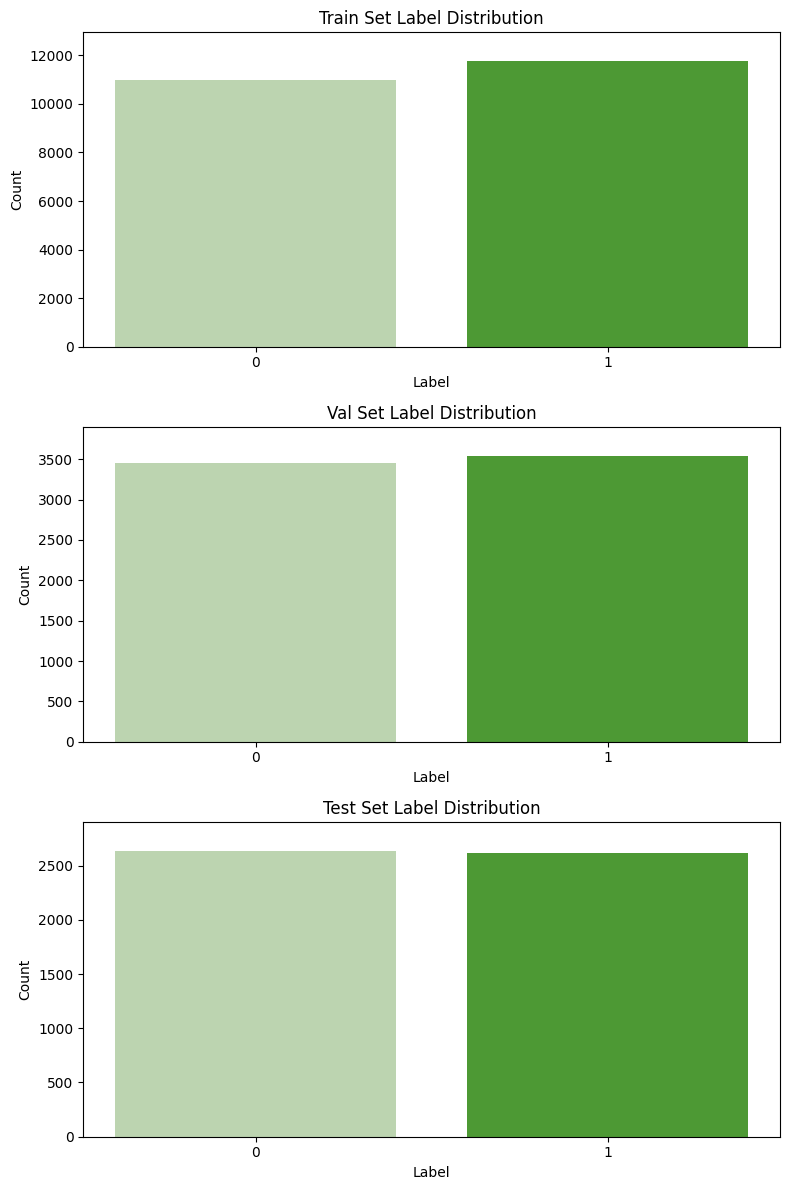

In [23]:
import matplotlib.pyplot as plt

# Define labels
labels = [0, 1]

# Initialize dictionaries to store label counts for each split
label_counts = {"train": {label: 0 for label in labels},
                "val": {label: 0 for label in labels},
                "test": {label: 0 for label in labels}}

# Iterate through each split
for split in ["train", "val", "test"]:
    # Get the split dataset
    split_data = dataset[split]

    # Iterate through each example in the split
    for example in split_data:
        # Increment the count for the label of the current example
        label_counts[split][example["label"]] += 1

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot for each split
for i, split in enumerate(["train", "val", "test"]):
    total_examples = sum(label_counts[split].values())
    labels_count = [label_counts[split][label] for label in labels]

    axs[i].bar(labels, labels_count, color=['#bcd4b0', '#4d9934'])
    axs[i].set_title(f"{split.capitalize()} Set Label Distribution")
    axs[i].set_xlabel('Label')
    axs[i].set_ylabel('Count')
    axs[i].set_xticks(labels)
    axs[i].set_xticklabels(labels)
    axs[i].set_ylim(0, max(labels_count) * 1.1)

plt.tight_layout()
plt.show()

**12. Model Preparation**

In [24]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [25]:
def preprocess_function(examples):
    encoded_inputs = tokenizer(examples["text"], truncation=True, padding=True, return_tensors="pt")
    encoded_inputs["labels"] = examples["label"]  # Add labels to the encoded inputs
    #print("Keys of encoded_inputs:", encoded_inputs.keys())  # Print keys for inspection
    return encoded_inputs


In [26]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/22750 [00:00<?, ? examples/s]

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5250 [00:00<?, ? examples/s]

In [27]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [28]:
id2label = {0: "fake", 1: "real"}
label2id = {"fake": 0, "real": 1}

In [29]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**13. Defining metrics**

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Compute accuracy, precision, recall, and F1 score as before
    accuracy = evaluate.load("accuracy").compute(predictions=predictions, references=labels)
    precision = evaluate.load("precision").compute(predictions=predictions, references=labels)
    recall = evaluate.load("recall").compute(predictions=predictions, references=labels)
    f1 = evaluate.load("f1").compute(predictions=predictions, references=labels)

    # Compute the classification matrix
    cf_matrix = confusion_matrix(labels, predictions)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cf_matrix': cf_matrix.tolist()  # Convert to list for compatible return type
    }


**14. Training**

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cf Matrix
1,0.182200,0.069569,{'accuracy': 0.9808571428571429},{'precision': 0.974380395433027},{'recall': 0.988138943801186},{'f1': 0.9812114413909141},"[[3367, 92], [42, 3499]]"
2,0.051800,0.064803,{'accuracy': 0.9841428571428571},{'precision': 0.9801231802911534},{'recall': 0.9887037560011296},{'f1': 0.9843947701391818},"[[3388, 71], [40, 3501]]"
3,0.017400,0.076881,{'accuracy': 0.9867142857142858},{'precision': 0.9839977540707467},{'recall': 0.9898333804010166},{'f1': 0.9869069407292693},"[[3402, 57], [36, 3505]]"


Trainer is attempting to log a value of "{'accuracy': 0.9808571428571429}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.974380395433027}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.988138943801186}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9812114413909141}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[3367, 92], [42, 3499]]" of type <class 'list'> fo

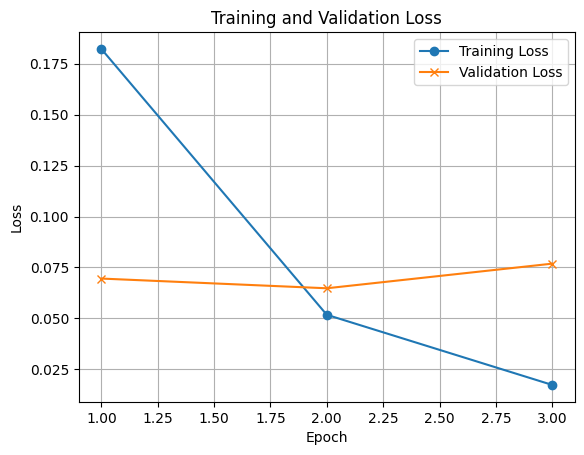

Trainer is attempting to log a value of "{'accuracy': 0.9841428571428571}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9801231802911534}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9887037560011296}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9843947701391818}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[3388, 71], [40, 3501]]" of type <class 'list'> 

***** eval metrics *****
  accuracy  =       0.9841428571428571
  cf_matrix = [[3388, 71], [40, 3501]]
  eval_loss =      0.06480304896831512
  f1        =       0.9843947701391818
  precision =       0.9801231802911534
  recall    =       0.9887037560011296


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cf Matrix
1,0.016700,0.083235,{'accuracy': 0.9852857142857143},{'precision': 0.9828651685393258},{'recall': 0.988138943801186},{'f1': 0.9854950007041262},"[[3398, 61], [42, 3499]]"
2,0.006400,0.083708,{'accuracy': 0.9868571428571429},{'precision': 0.9861855088807443},{'recall': 0.9878565377012144},{'f1': 0.9870203160270882},"[[3410, 49], [43, 3498]]"


Trainer is attempting to log a value of "{'accuracy': 0.9852857142857143}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9828651685393258}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.988138943801186}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9854950007041262}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[3398, 61], [42, 3499]]" of type <class 'list'> f

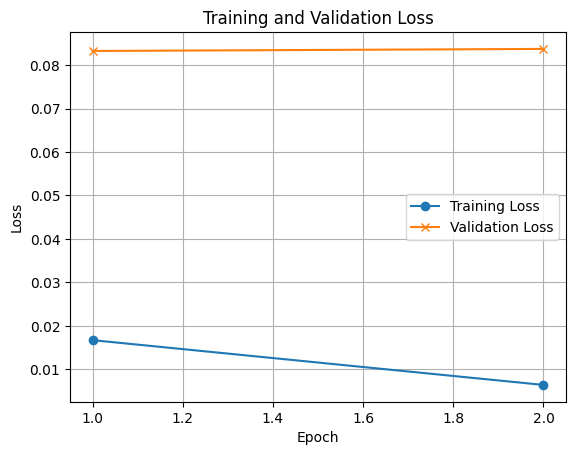

Trainer is attempting to log a value of "{'accuracy': 0.9852857142857143}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9828651685393258}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.988138943801186}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9854950007041262}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[3398, 61], [42, 3499]]" of type <class 'list'> f

***** eval metrics *****
  accuracy  =       0.9852857142857143
  cf_matrix = [[3398, 61], [42, 3499]]
  eval_loss =      0.08323459327220917
  f1        =       0.9854950007041262
  precision =       0.9828651685393258
  recall    =        0.988138943801186


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cf Matrix
1,0.005200,0.126741,{'accuracy': 0.9844285714285714},{'precision': 0.9798657718120806},{'recall': 0.9895509743010449},{'f1': 0.9846845581003233},"[[3387, 72], [37, 3504]]"
2,0.004500,0.099042,{'accuracy': 0.9871428571428571},{'precision': 0.9848271986513065},{'recall': 0.9898333804010166},{'f1': 0.9873239436619718},"[[3405, 54], [36, 3505]]"


Trainer is attempting to log a value of "{'accuracy': 0.9844285714285714}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9798657718120806}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9895509743010449}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9846845581003233}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[3387, 72], [37, 3504]]" of type <class 'list'> 

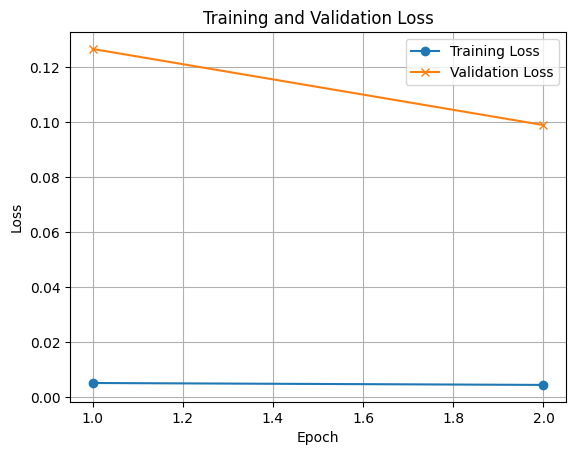

Trainer is attempting to log a value of "{'accuracy': 0.9871428571428571}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9848271986513065}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9898333804010166}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9873239436619718}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[3405, 54], [36, 3505]]" of type <class 'list'> 

***** eval metrics *****
  accuracy  =       0.9871428571428571
  cf_matrix = [[3405, 54], [36, 3505]]
  eval_loss =      0.09904198348522186
  f1        =       0.9873239436619718
  precision =       0.9848271986513065
  recall    =       0.9898333804010166
Best F1 score: 0.9873239436619718
Best hyperparameters: {'learning_rate': 2e-05, 'num_train_epochs': 2}


In [31]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
import random

hyperparameter_grid = {
    "learning_rate": [5e-5, 3e-5, 2e-5],
    "num_train_epochs": [2, 3, 4]
}

best_f1_score = -1
best_hyperparameters = None

for param in model.distilbert.transformer.layer[:4].parameters():
    param.requires_grad = False

#Performing Random Search
for _ in range(3):

    hyperparameters = {
        "learning_rate": random.choice(hyperparameter_grid["learning_rate"]),
        "num_train_epochs": random.choice(hyperparameter_grid["num_train_epochs"]),
    }

    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        num_train_epochs=hyperparameters["num_train_epochs"],
        learning_rate=hyperparameters["learning_rate"],
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss"
    )

    # Create EarlyStoppingCallback
    early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["val"],
        compute_metrics=compute_metrics,
        callbacks=[early_stopping]  # Include EarlyStoppingCallback
    )

    # Train the model
    trainer.train()

    train_losses = []
    eval_losses = []

    for entry in trainer.state.log_history:
        if 'loss' in entry:
            train_losses.append((entry['epoch'], entry['loss']))
        elif 'eval_loss' in entry:
            eval_losses.append((entry['epoch'], entry['eval_loss']))

    train_epochs, train_loss_values = zip(*train_losses)
    eval_epochs, eval_loss_values = zip(*eval_losses)

    plt.plot(train_epochs, train_loss_values, label='Training Loss', marker='o')
    plt.plot(eval_epochs, eval_loss_values, label='Validation Loss', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate the model
    evaluation_results = trainer.evaluate()

    eval_loss = evaluation_results["eval_loss"]
    accuracy = evaluation_results["eval_accuracy"]["accuracy"]
    precision = evaluation_results["eval_precision"]["precision"]
    recall = evaluation_results["eval_recall"]["recall"]
    f1_score = evaluation_results["eval_f1"]["f1"]
    cf_matrix = evaluation_results["eval_cf_matrix"]

    # Extract scalar values for logging
    metrics = {
        "eval_loss": eval_loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1_score,
        "cf_matrix": cf_matrix
    }

    # Convert metrics values to strings for formatting
    metrics_formatted = {key: str(value) for key, value in metrics.items()}

    # Log metrics for evaluation split
    trainer.log_metrics("eval", metrics_formatted)

    # Update best hyperparameters if F1 score improved
    if f1_score > best_f1_score:
        best_f1_score = f1_score
        best_hyperparameters = hyperparameters

print("Best F1 score:", best_f1_score)
print("Best hyperparameters:", best_hyperparameters)


**15. Testing**

In [32]:
best_learning_rate = best_hyperparameters['learning_rate']
best_num_train_epochs = best_hyperparameters['num_train_epochs']

print("Best learning rate: ",best_learning_rate)
print("Best num of train epochs: ",best_num_train_epochs)

Best learning rate:  2e-05
Best num of train epochs:  2


In [33]:
best_hyperparameters = {
    "learning_rate": best_learning_rate,
    "num_train_epochs": best_num_train_epochs
}
best_hyperparameters

{'learning_rate': 2e-05, 'num_train_epochs': 2}

In [34]:
# Initialize Trainer with the best hyperparameters
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=best_hyperparameters["num_train_epochs"],
    learning_rate=best_hyperparameters["learning_rate"],
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss"
)

# Create EarlyStoppingCallback if needed
early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

# Initialize Trainer with best hyperparameters and callbacks
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]  # Include EarlyStoppingCallback if needed
)

trainer.train()

# Evaluate the model
evaluation_results = trainer.evaluate()

accuracy = evaluation_results["eval_accuracy"]["accuracy"]
precision = evaluation_results["eval_precision"]["precision"]
recall = evaluation_results["eval_recall"]["recall"]
f1_score = evaluation_results["eval_f1"]["f1"]
cf_matrix = evaluation_results["eval_cf_matrix"]

# Extract scalar values for logging
metrics = {
      "accuracy": accuracy,
      "precision": precision,
      "recall": recall,
      "f1": f1_score,
      "cf_matrix": cf_matrix
    }

# Convert metrics values to strings for formatting
metrics_formatted = {key: str(value) for key, value in metrics.items()}

# Log metrics for evaluation split
trainer.log_metrics("eval", metrics_formatted)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cf Matrix
1,0.001900,0.174923,{'accuracy': 0.9847619047619047},{'precision': 0.9888160431932125},{'recall': 0.9804971319311664},{'f1': 0.9846390168970814},"[[2606, 29], [51, 2564]]"
2,0.004300,0.143917,{'accuracy': 0.9853333333333333},{'precision': 0.9839816933638444},{'recall': 0.9866156787762906},{'f1': 0.9852969257208326},"[[2593, 42], [35, 2580]]"


Trainer is attempting to log a value of "{'accuracy': 0.9847619047619047}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9888160431932125}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9804971319311664}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9846390168970814}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[2606, 29], [51, 2564]]" of type <class 'list'> 

Trainer is attempting to log a value of "{'accuracy': 0.9853333333333333}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9839816933638444}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9866156787762906}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9852969257208326}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[2593, 42], [35, 2580]]" of type <class 'list'> 

***** eval metrics *****
  accuracy  =       0.9853333333333333
  cf_matrix = [[2593, 42], [35, 2580]]
  f1        =       0.9852969257208326
  precision =       0.9839816933638444
  recall    =       0.9866156787762906


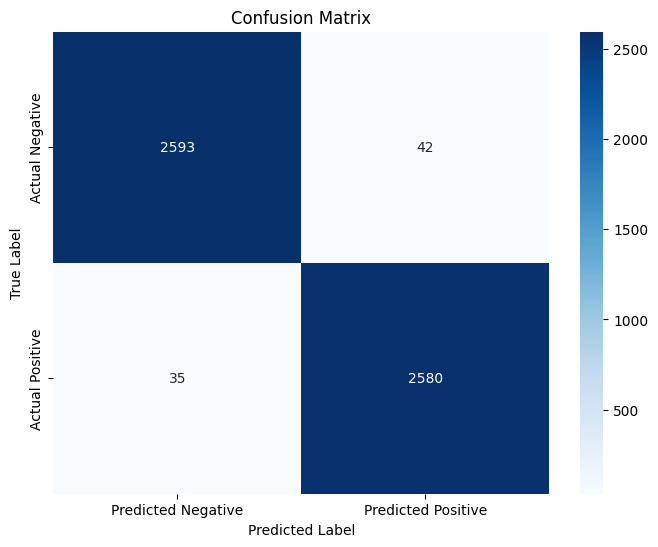

In [35]:
import seaborn as sns
# Extract the confusion matrix from evaluation_results
cf_matrix = evaluation_results["eval_cf_matrix"]

# Convert the confusion matrix from a list of lists to a numpy array
cf_matrix = np.array(cf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [36]:
pip install bertviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 11.7 MB/s eta 0:00:00


In [37]:
from bertviz import head_view
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load pre-trained ELECTRA model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", output_attentions=True)

# Define input text
text = "unbelievable! obama’s attorney general says most charlotte rioters were “peaceful” protesters…"

# Tokenize the input text
inputs = tokenizer.encode(text, return_tensors='pt')

# Forward pass through the model
outputs = model(inputs)
attention = outputs[-1]  # Output includes attention weights when output_attentions=True
tokens = tokenizer.convert_ids_to_tokens(inputs[0])

# Generate visualization
head_view(attention, tokens)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

In [ ]:
from bertviz import model_view

model_view(attention,tokens)

<IPython.core.display.Javascript object>